In [1]:
import sys
sys.path.append('/home/jovyan/QNN4RadarImage/')

In [2]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

# Lenet-5

In [3]:
kernel_size = 3
stride = 1

lenet_5_model = Sequential()
lenet_5_model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, activation='relu', padding='same', input_shape = (64,64,3)))
lenet_5_model.add(AveragePooling2D())
lenet_5_model.add(Conv2D(32, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
lenet_5_model.add(AveragePooling2D())
lenet_5_model.add(Conv2D(64, kernel_size=kernel_size, strides=stride, activation='relu', padding='valid'))
lenet_5_model.add(AveragePooling2D())

lenet_5_model.add(Flatten())
lenet_5_model.add(Dense(128, activation='relu'))
lenet_5_model.add(Dense(64, activation='relu'))
lenet_5_model.add(Dense(32, activation='relu'))
lenet_5_model.add(Dense(10, activation='softmax'))

lenet_5_model.compile(optimizer=SGD(lr=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
lenet_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 32, 32, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_2 (Averag  (None, 6, 6, 64)         0

/opt/conda/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Load Dataset

In [4]:
from DatasetHandler import DatasetHandler

dataset_root = '/home/jovyan/QNN4RadarImage/datasets/EuroSAT/'
handler = DatasetHandler(dataset_root)

In [5]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
  print('Class %d -> %s' % (i, cl))

Class 0 -> Residential
Class 1 -> PermanentCrop
Class 2 -> Industrial
Class 3 -> AnnualCrop
Class 4 -> Highway
Class 5 -> Forest
Class 6 -> Pasture
Class 7 -> SeaLake
Class 8 -> HerbaceousVegetation
Class 9 -> River


In [6]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /home/jovyan/QNN4RadarImage/datasets/EuroSAT/Residential/Residential_1734.jpg 7


In [7]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


In [8]:
batch_size = 1
epochs = 100

train_gen = handler.cnn_data_loader(train_imgs, train_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)
val_gen = handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10)


es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

history = lenet_5_model.fit(train_gen,
                            steps_per_epoch = len(train_labels)//batch_size,
                            epochs = epochs,
                            validation_data = val_gen,
                            validation_steps = len(val_labels)//batch_size,
                            callbacks = [es])

Epoch 1/100
21600/21600 [==============================] - 119s 5ms/step - loss: 2.1883 - accuracy: 0.2008 - val_loss: 1.8733 - val_accuracy: 0.2744
Epoch 2/100
21600/21600 [==============================] - 118s 5ms/step - loss: 1.7642 - accuracy: 0.3309 - val_loss: 1.7300 - val_accuracy: 0.3622
Epoch 3/100
21600/21600 [==============================] - 118s 5ms/step - loss: 1.6823 - accuracy: 0.3698 - val_loss: 1.7011 - val_accuracy: 0.3731
Epoch 4/100
21600/21600 [==============================] - 116s 5ms/step - loss: 1.6208 - accuracy: 0.3966 - val_loss: 1.6573 - val_accuracy: 0.3809
Epoch 5/100
21600/21600 [==============================] - 118s 5ms/step - loss: 1.5368 - accuracy: 0.4347 - val_loss: 1.5442 - val_accuracy: 0.4346
Epoch 6/100
21600/21600 [==============================] - 118s 5ms/step - loss: 1.4331 - accuracy: 0.4856 - val_loss: 1.4072 - val_accuracy: 0.4993
Epoch 7/100
21600/21600 [==============================] - 117s 5ms/step - loss: 1.3498 - accuracy: 0.5221

In [9]:
lenet_5_model.save('/home/jovyan/QNN4RadarImage/JSTARS2021/classical_classifiers/saved_models_new/lenet5-v2.h5')

In [11]:
import numpy as np
val_gen = iter(handler.cnn_data_loader(val_images, val_labels, batch_size=batch_size, img_shape=(64,64,3), n_classes=10))


predictions = []
targets = []

count = 0

for ct in range(len(val_images)):
    
    count = count + 1
    if count % 100 == 0:
        print('Predicting validation images: ' + str(count) + ' / ' + str(val_images.shape[0]))
    
    data, target = next(val_gen)
    output = lenet_5_model.predict(data, verbose = 0)
    
    predictions.append(np.argmax(output))
    targets.append(np.argmax(target))
  

Predicting validation images: 100 / 5400
Predicting validation images: 200 / 5400
Predicting validation images: 300 / 5400
Predicting validation images: 400 / 5400
Predicting validation images: 500 / 5400
Predicting validation images: 600 / 5400
Predicting validation images: 700 / 5400
Predicting validation images: 800 / 5400
Predicting validation images: 900 / 5400
Predicting validation images: 1000 / 5400
Predicting validation images: 1100 / 5400
Predicting validation images: 1200 / 5400
Predicting validation images: 1300 / 5400
Predicting validation images: 1400 / 5400
Predicting validation images: 1500 / 5400
Predicting validation images: 1600 / 5400
Predicting validation images: 1700 / 5400
Predicting validation images: 1800 / 5400
Predicting validation images: 1900 / 5400
Predicting validation images: 2000 / 5400
Predicting validation images: 2100 / 5400
Predicting validation images: 2200 / 5400
Predicting validation images: 2300 / 5400
Predicting validation images: 2400 / 5400
P

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(predictions, targets, normalize='true')

S2
Accuracy: [0.77669903 0.9582505  0.79334501 0.7400722  0.92989691 0.77562327
 0.54448871 0.92982456 0.73891626 0.87136294] mean:  0.8058479382637479
                      precision    recall  f1-score   support

         Residential     0.7767    0.7869    0.7818       610
       PermanentCrop     0.9583    0.8087    0.8772       596
          Industrial     0.7933    0.7512    0.7717       603
          AnnualCrop     0.7401    0.4262    0.5409       481
             Highway     0.9299    0.8757    0.9020       515
              Forest     0.7756    0.7349    0.7547       381
             Pasture     0.5445    0.8524    0.6645       481
             SeaLake     0.9298    0.8968    0.9130       591
HerbaceousVegetation     0.7389    0.8182    0.7765       550
               River     0.8714    0.9611    0.9141       592

            accuracy                         0.7981      5400
           macro avg     0.8058    0.7912    0.7896      5400
        weighted avg     0.8125    0.798

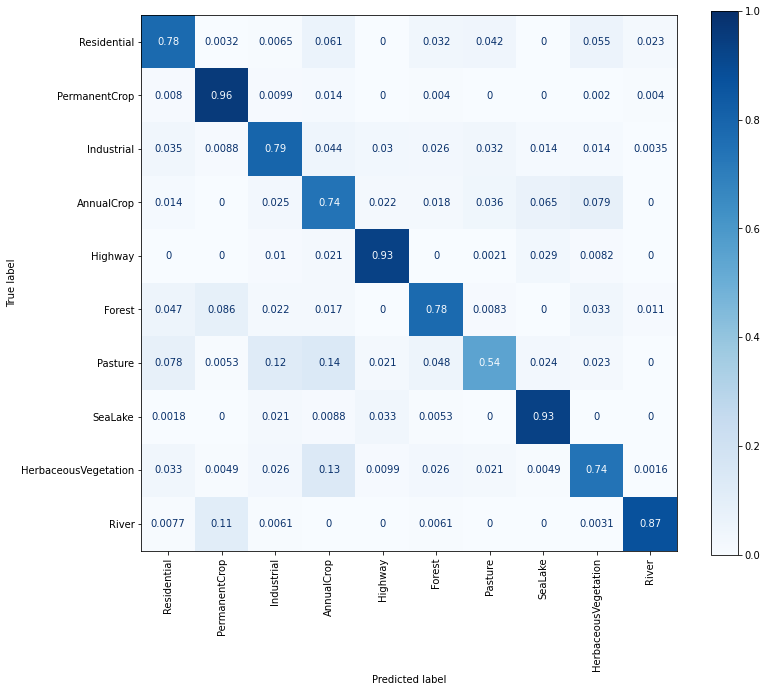

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()